In [102]:
import pandas as pd
import matplotlib.pyplot as plt 
import os
import warnings
from datetime import datetime

from skimage.morphology import square, dilation, disk
from skimage.feature import canny
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,denoise_wavelet, estimate_sigma)
from skimage.filters import median

from skimage.io import imread, imsave
from skimage.color import rgb2gray
import cv2

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from scipy.signal import butter, lfilter
import numpy as np
from itertools import product
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
import lightgbm as lgb

#from Networks import *
#from Comp2_func import *
from IOU import *
from sklearn.metrics import mean_squared_error
import gc
warnings.filterwarnings("ignore")

In [129]:
def im_load():
    img_path= 'train_data/train_images/'
    msk_path= 'train_data/train_masks/'
    imx_bank= []
    imy_bank= []
    depths= []
    depth_data= pd.read_csv('depths.csv')
    for root, dirs, files in os.walk(img_path + '.'):  
        for file_name in files:
            imx= imread(img_path + file_name)
            imy= imread(msk_path + file_name)
            depth= depth_data['z'][depth_data['id']==file_name.split('.')[0]]

            imx= rgb2gray(imx)
            imy= imy / 65535
            if imx.max()>0:
                
                #imx= (imx - np.mean(imx)) / np.std(imx)
                size= (63, 63)
                imx= cv2.resize(imx, size)
                imy= cv2.resize(imy, size)
                
                imx_bank.append(imx)
                imy_bank.append(imy)
                depths.append(depth.values * np.ones((63*63, )).astype(int))  

    imx_bank= np.array(imx_bank)
    imy_bank= np.array(imy_bank)
    depths= np.array(depths)
    return imx_bank, imy_bank, depths

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def BP_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data= np.rot90(data)
    y = lfilter(b, a, data)
    y= np.rot90(y, k=1, axes=(1,0))
    return y

def BP_filter90(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #data= np.rot90(data)
    y = lfilter(b, a, data)
    #y= np.rot90(y, k=1, axes=(1,0))
    return y

def bp(X, lowcut, highcut, order):
    imx_bank= []
    for imx in X:
        bp= BP_filter(imx, lowcut=lowcut, highcut=highcut, fs=1/0.004, order=order)
        imx_bank.append(bp/1.3)
    imx_bank= np.array(imx_bank)
    return imx_bank


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def binary_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_coef(y_true, y_pred))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef1(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = np.sum(np.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (np.sum(np.square(y_true),-1) + np.sum(np.square(y_pred),-1) + smooth)


# Show images
def show_im(X, y, imp):
    #imy= np.squeeze(y)
    #imx_show= np.squeeze(X)
    #imp= np.squeeze(imp, axis=[0, -1])

    fig, (ax1, ax2, ax3)= plt.subplots(1, 3)
    ax1.imshow(X)
    ax2.imshow(y)
    ax3.imshow(imp)
    plt.show()

In [45]:
print('Loading images')
X, y, d= im_load()

Loading images


In [48]:
X.shape

(3920, 63, 63)

In [67]:
variations= []
low= [0.1, 2, 5, 10, 20] 
high= [7, 10, 20, 30, 40]
order= [2, 3, 5]
variations_prod= list(product(*[low, high, order]))
[variations.append(x) for x in variations_prod if x[1]>x[0]]

XB= np.zeros((X.shape[0] * X.shape[1] * X.shape[2], len(variations)))
for i, variation in enumerate(variations): 
    XB[:, i]= bp(X, lowcut=variation[0], highcut=variation[1], order=variation[2]).flatten() #reshape((X.shape[0], X.shape[1] * X.shape[2] ))

In [82]:

X_f= np.expand_dims(X.flatten(), axis=1)
d_f= np.expand_dims(d.flatten(), axis=1)

y_f= y.flatten()

In [85]:
X_modeling= np.hstack((X_f, XB, d_f))

In [86]:
X_modeling.shape

(15558480, 62)

In [139]:
#BRmodel= BayesianRidge()
#BRmodel.fit(X_modeling, y_f)
#p= BRmodel.predict(X_modeling)

lgb_params= {'feature_fraction': 0.7,'metric': 'rmse', 'nthread':12, 'min_data_in_leaf': 2**7, 
                  'bagging_fraction': 0.7, 'learning_rate': 0.05, 'objective': 'rmse',
                  'bagging_seed': 2**5, 'num_leaves': 2**11,'bagging_freq':1,'verbose':0}
LGBmodel = lgb.train(lgb_params, lgb.Dataset(X_modeling, label=y_f), 300)
p= LGBmodel.predict(X_modeling)
print(np.sqrt(mean_squared_error(y_f, p)))

0.2796436340344427


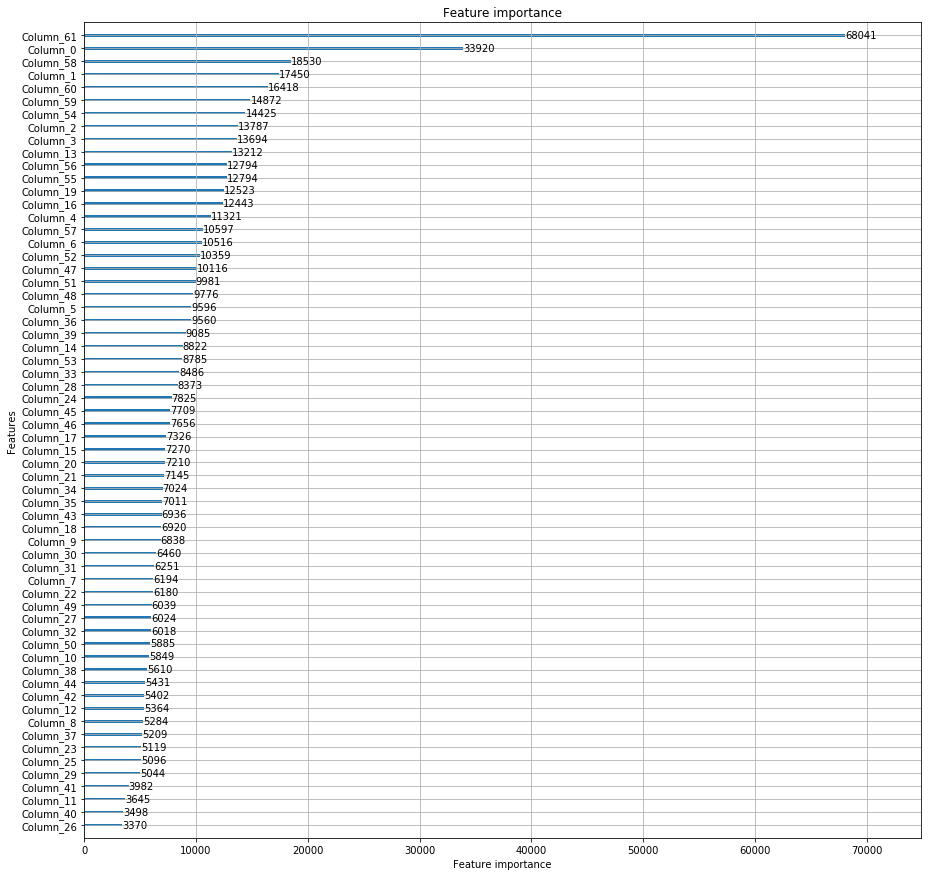

In [140]:
ax = lgb.plot_importance(LGBmodel, figsize=(15, 15));plt.show()

In [141]:
p.max()

1.5859788496736977

max dice is 0.7929308128405406at threshold 0.3699999999999999


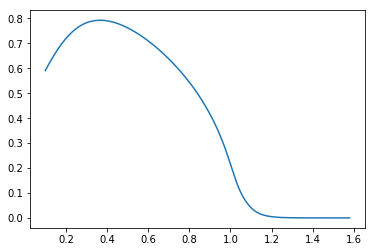

In [164]:
dice= []
thresholds= np.arange(0.1, p.max(), 0.01)
for threshold in thresholds:
    p_test= np.zeros((p.shape))
    #print('th: ', np.round(threshold, decimals= 2))
    p_test[p> threshold]= 1
    p_test= p_test.astype(np.float32)
    y_true= y_f.astype(np.float32)
    #print(np.sqrt(mean_squared_error(y_f, p_test)))
    dice.append(dice_coef1(y_true, p_test))
plt.plot(thresholds, dice)
max_dice= np.array(dice).max()
best_th= thresholds[np.argmax(np.array(dice))]
print('max dice is ' + str(max_dice) + 'at threshold ' + str(best_th))

In [167]:
p_final= np.zeros((p.shape))
p_final[p> best_th]= 1

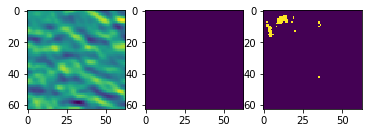

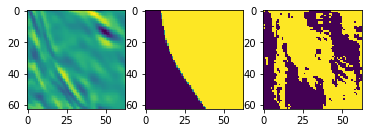

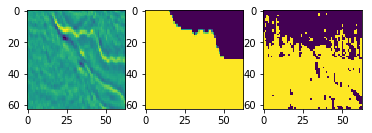

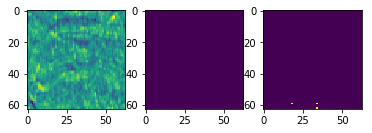

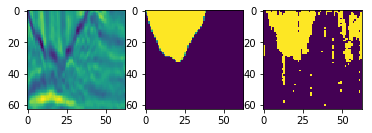

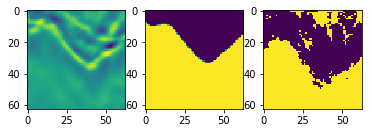

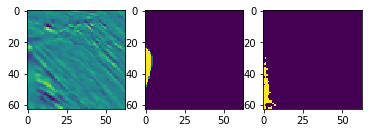

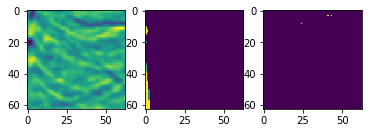

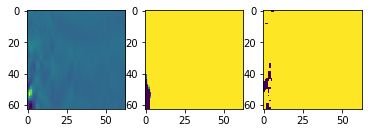

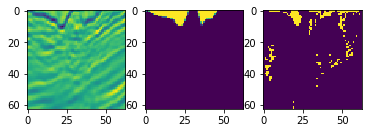

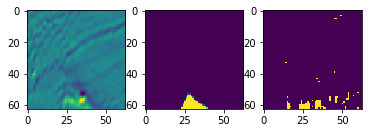

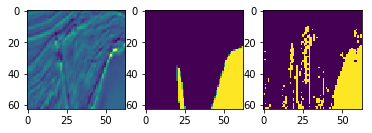

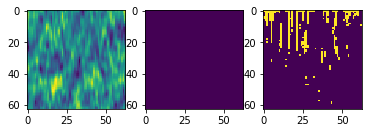

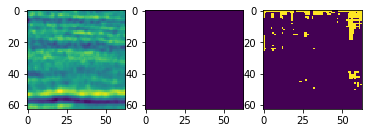

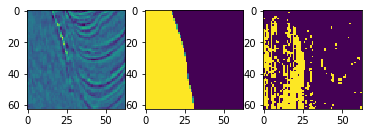

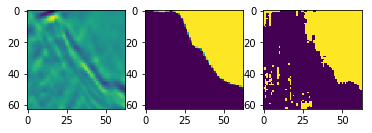

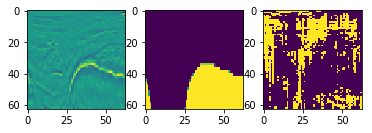

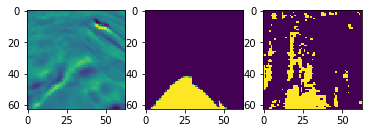

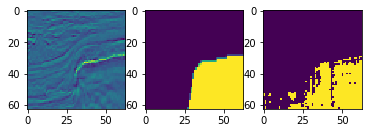

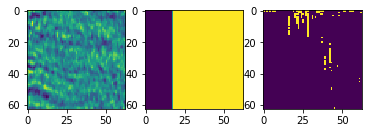

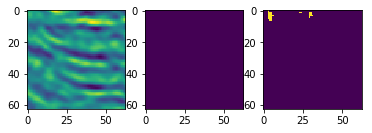

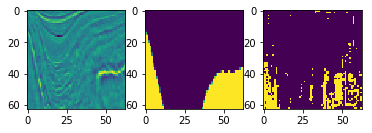

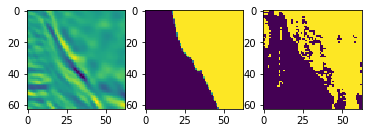

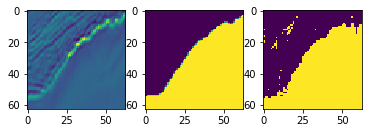

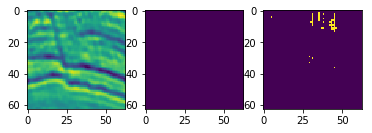

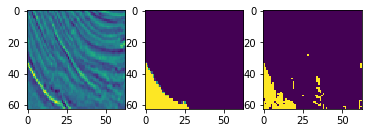

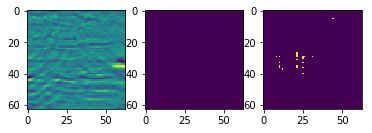

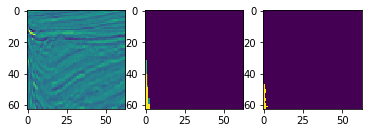

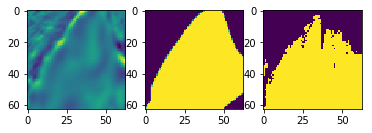

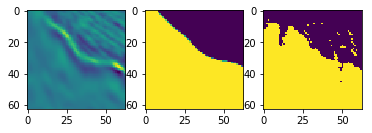

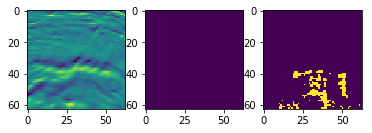

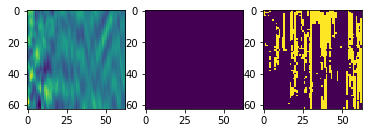

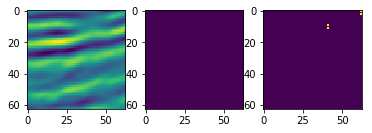

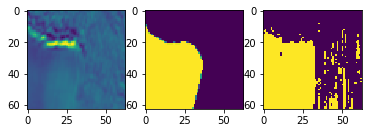

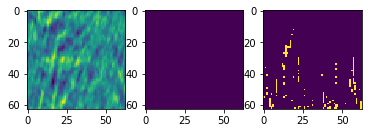

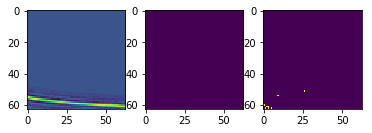

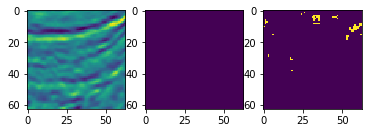

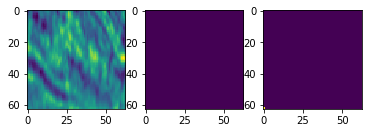

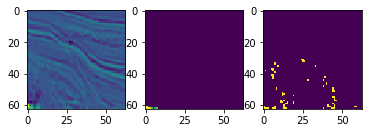

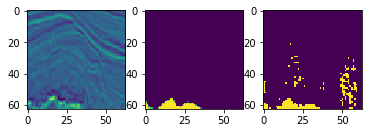

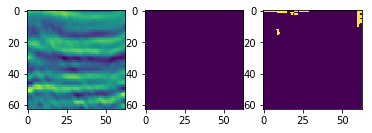

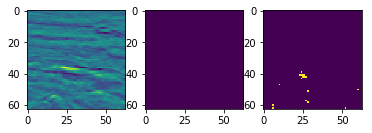

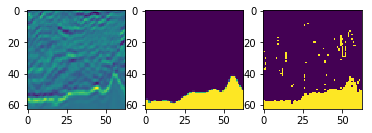

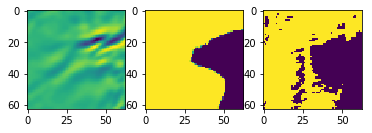

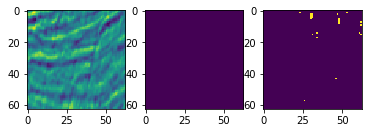

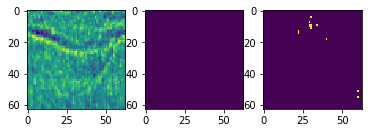

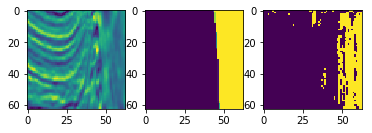

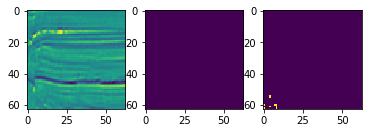

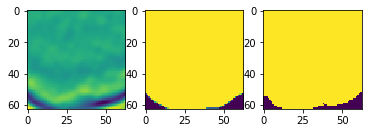

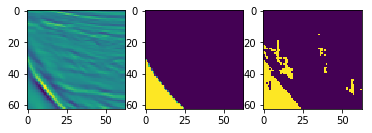

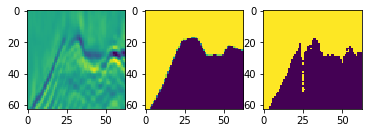

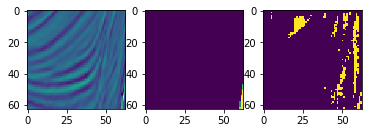

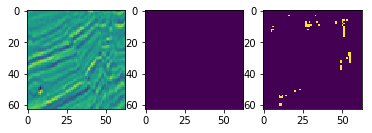

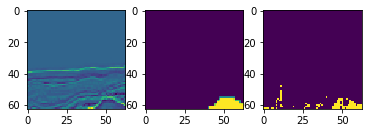

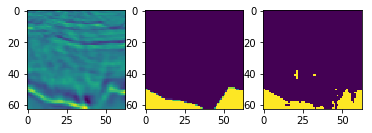

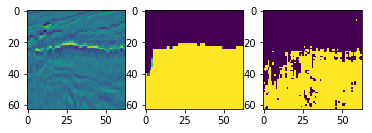

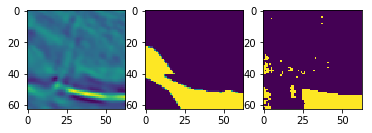

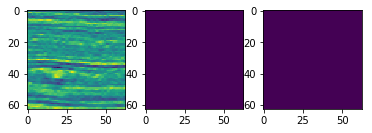

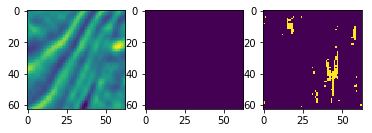

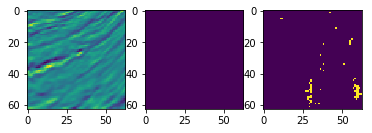

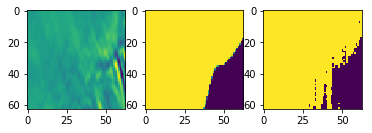

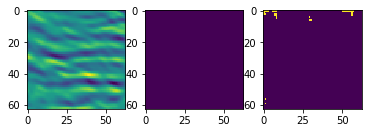

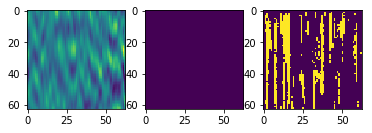

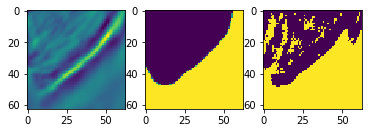

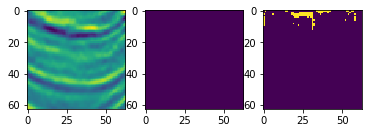

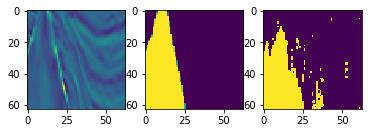

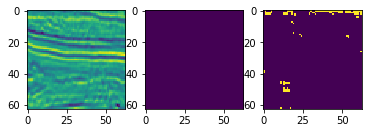

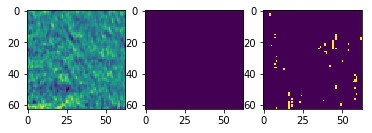

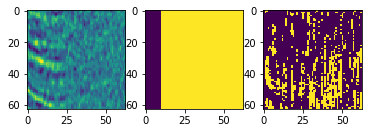

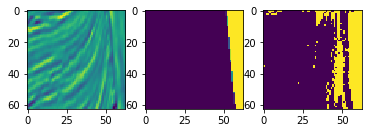

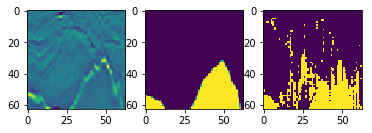

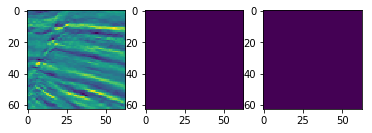

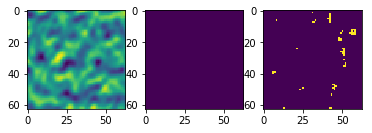

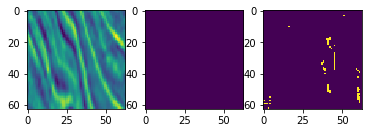

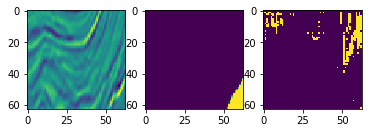

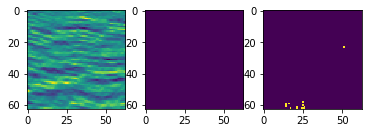

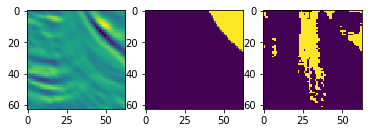

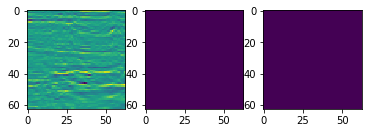

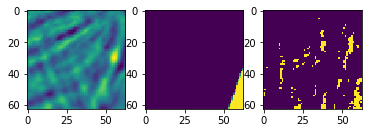

In [168]:
imp= p_final.reshape((-1, 63, 63))
y_c= y_true.reshape((-1, 63, 63))

for i in np.arange(0, len(X), 50):
    show_im(X[i], y_c[i], imp[i])
